**Statlog Shuttle Radiator data**

![title](images/shuttle.jpg)

Statlog Shuttle dataset describes radiator positions in a NASA space with 9 attributes and was designed for supervised anomaly detection. There are 7 classes, which are coded as follows : 
- Rad Flow 1 (normal status）
- Fpv Close 2
- Fpv Open 3
- High 4
- Bypass 5
- Bpv Close 6
- Bpv Open 7

Besides **Rad flow and High** classes, the rest classes (about 1.86% of the data) describe abnormal situations.  It contains in total 9 attributes all of which are numerical. But the meaning of each attribute is not stated. It can be speculated that these nine attributes may be derived from the pressure, temperature sensors.

This notebook is divided into 3 parts.

    1.  Data exploration. 
    2.  Anomaly detection with supervised learning
    3.  Anomaly detection with unsupervised learning 

**Anomaly detection**

Anomaly detection refers to the problem of finding patterns in data that do not conform to expected behavior.  Multidimensional data points may be anomalous because, in one or more dimensions, the value lies outside of an expected range, or because an expected correlation between two or more dimensions is violated. 

For example, suppose a thermostat reports periodic updates of
an observed temperature and a setpoint temperature. An anomaly may occur when the observed temperature exceeds the normal range (i.e., too hot or too cold), or when the observed temperature and setpoint temperature values no longer correlate, even if both values themselves fall within normal ranges (i.e., the climate control device fails to maintain a desired setpoint temperature)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from scipy.io import loadmat
from sklearn.metrics import plot_confusion_matrix
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all" 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
size=20
params = {
          'axes.labelsize': size,
        
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75}
plt.rcParams.update(params)

# Data Exploration

- **Load  Data**

    Since the meaning of each attribute is not known, the 9 attributes are named as a1 to a9 for simplicity.

In [2]:
train_col_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'Class']

training_data = pd.read_csv("data/train.csv", index_col=[0],header=[0])

training_data.columns = train_col_names

print("The shape of training dataset is ", training_data.shape)

The shape of training dataset is  (43500, 10)


    The following table shows the first five rows of data, each row being a data point consisting of nine attributes and the corresponding class. We have a total of 43,500 data points.

In [3]:
training_data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,Class
Id,,,,,,,,,,
0,50,21,77,0,28,0,27,48,22,2
1,55,0,92,0,0,26,36,92,56,4
2,53,0,82,0,52,-5,29,30,2,1
3,37,0,76,0,28,18,40,48,8,1
4,37,0,79,0,34,-26,43,46,2,1


- **check label distribution**

    The following figure shows the distribution of the 9 classes. Approximately 93.9% of the data belongs to classes 1 and 4, which means normal status.  This distribution corresponds to reality. In practical application, the machine operates in its normal state most of the time. The data points generated at this time are normal. Anomaly by definition are rare.

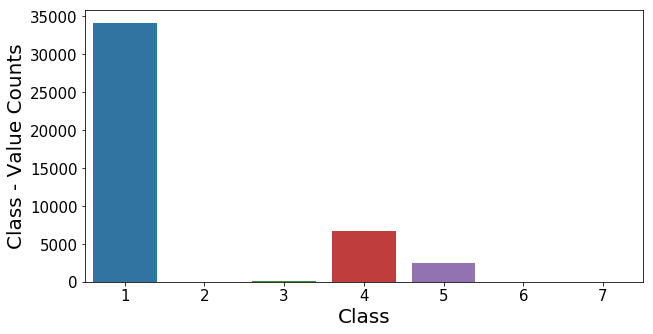

In [4]:
plt.figure(figsize=(10,5))
sns.countplot(training_data["Class"])
plt.xlabel("Class")
plt.ylabel("Class - Value Counts")
plt.show()

- **check correlation**

    A pairplot plot a pairwise relationships in a dataset. It creates a grid of Axes such that each variable in data will by shared in the y-axis across a single row and in the x-axis across a single column. The main-diagonal subplots are the univariate histograms (distributions) for each attribute.

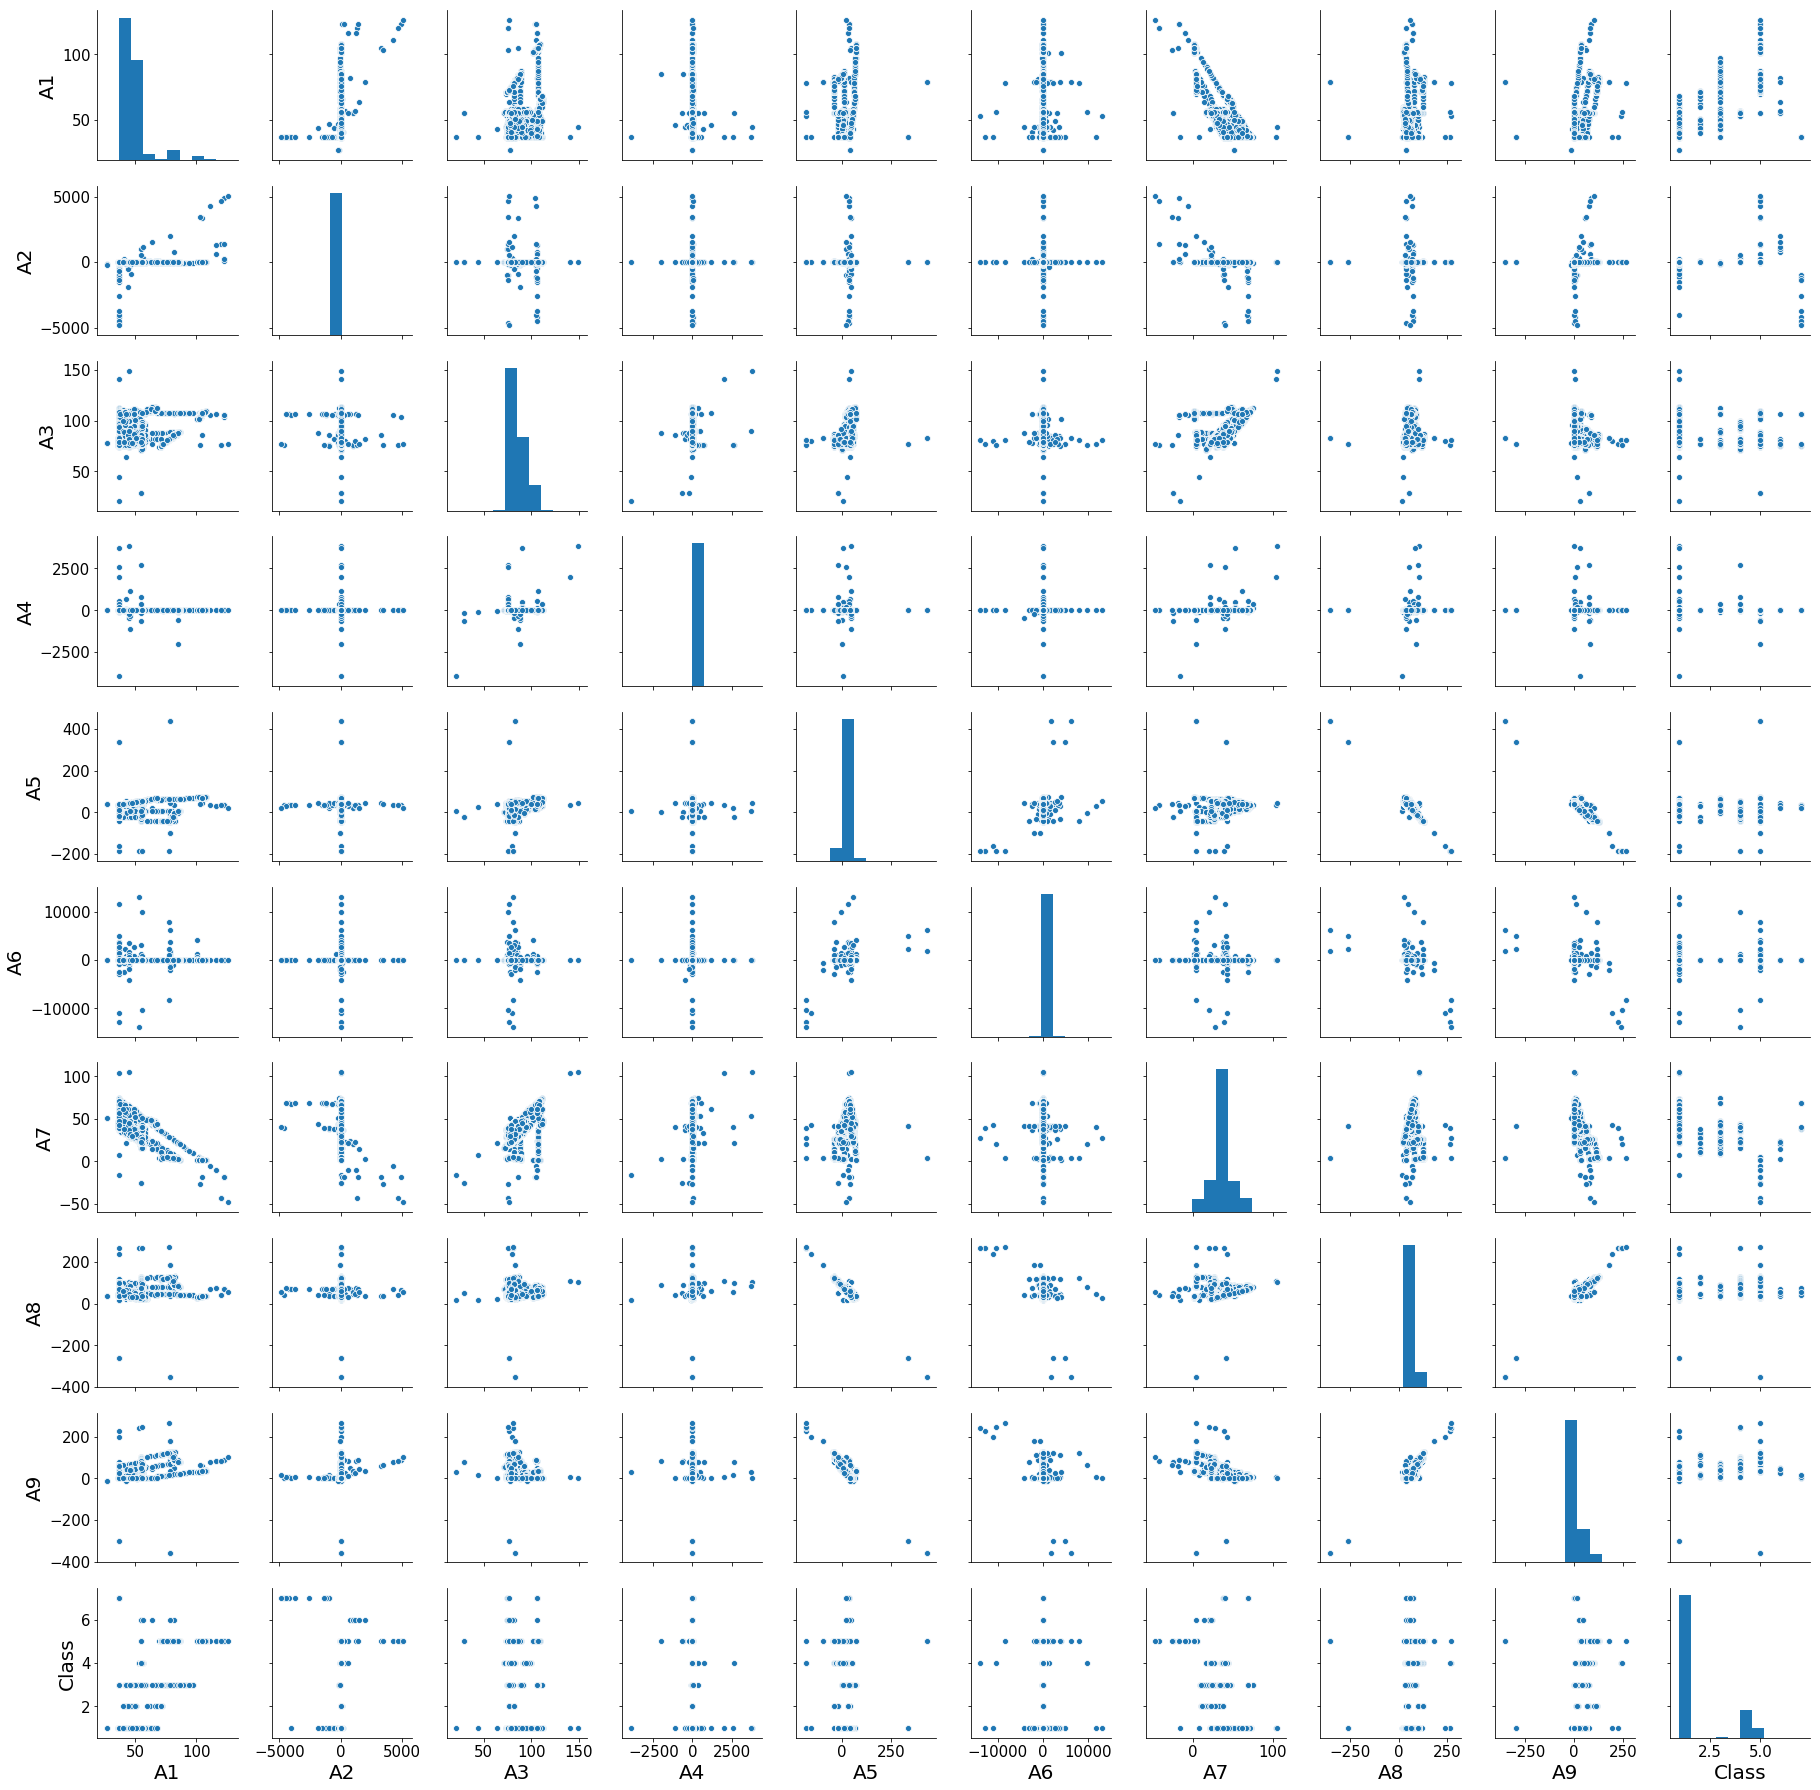

In [5]:
g = sns.pairplot(training_data)
g.fig.set_size_inches(25,25)

    A boxplot is another graph plot which is often used to analyze the relationship between a categorical attribute  and a continuous attribute
     
    attribute A4 and A6 are similarly distributed in each class. That is to say, they are not related to class.
    Other features have obvious different distributions on different classes. they are important features to predict the class!

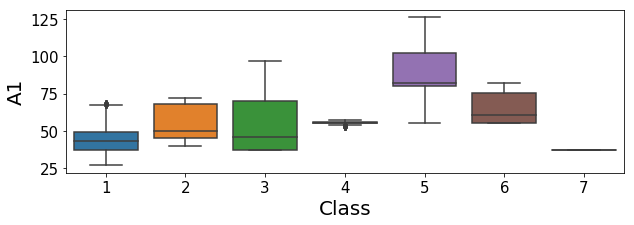

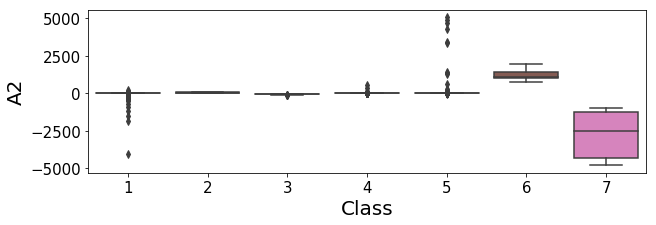

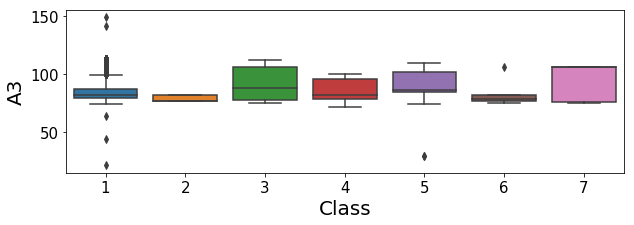

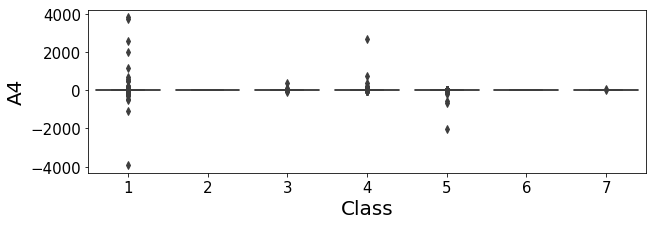

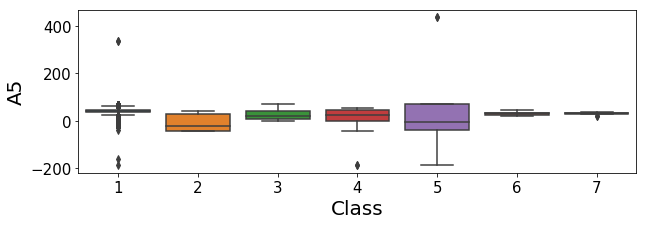

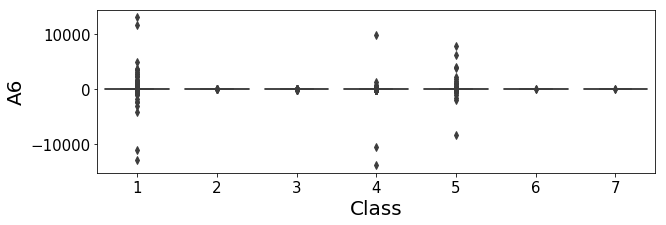

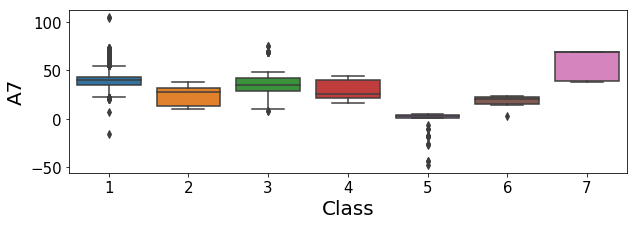

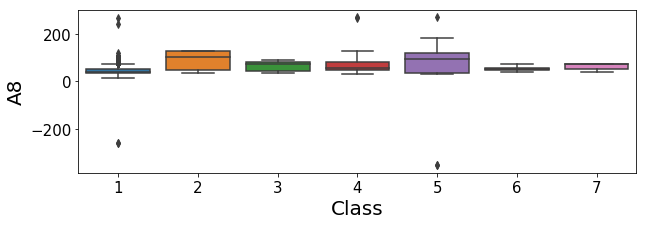

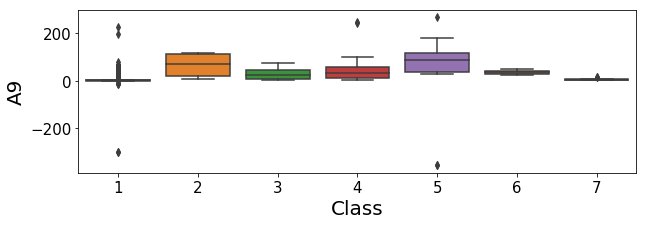

In [6]:
for i in range(9):
    plt.figure(figsize=(10,3))
    sns.boxplot(x="Class", y=training_data.columns[i], data=training_data)
    plt.show()

# Anomaly detection with supervised learning

- **train test split**
    
    the dataset is split into 2 data sets. one is training dataset, one is test dataset.
    - training dataset : is used to train the model
    - test dataset : is used to evaluate the model's performance. the data in test dataset have not been "seen" by the model

In [7]:
data = training_data.sample(frac=1,random_state=42)
split = int(data.shape[0]*0.8)
train = data.iloc[:split,:]
test = data.iloc[split:,:]

train_y = train["Class"]
train_x = train.drop(columns=["Class"])
test_y = test["Class"]
test_x = test.drop(columns=["Class"])


    Since, the range of values of data may vary widely, 
    It becomes a necessary step in data preprocessing while using machine learning algorithms
    Normalization is the method used to standardize the range of each attribute 

In [8]:
mean_of_train = train_x.mean()
std_of_train = train_x.std()
std_of_train.replace(0, 1, inplace=True)
train_x = (train_x - mean_of_train) / std_of_train
test_x = (test_x - mean_of_train) / std_of_train

- **RandomForestClassifier**

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=500)
rf_clf.fit(train_x, train_y)
y_pred_rf = rf_clf.predict(test_x)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

accuracy_rf = accuracy_score(test_y, y_pred_rf)
precision_rf = precision_score(test_y, y_pred_rf, average='macro')
recall_rf = recall_score(test_y, y_pred_rf, average='macro')

print("\nRandomForestClassifier (n_estimators = 500) model metrics are:")
print("Accuracy = {0:.4f}, Precision = {1:.4f} & Recall = {2:.4f}\n".format(accuracy_rf, precision_rf, recall_rf))


RandomForestClassifier (n_estimators = 500) model metrics are:
Accuracy = 0.9993, Precision = 0.8405 & Recall = 0.7981



In [11]:
print(classification_report(test_y, y_pred_rf))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6836
           2       1.00      1.00      1.00         7
           3       0.88      0.92      0.90        25
           4       1.00      1.00      1.00      1367
           5       1.00      1.00      1.00       457
           6       0.00      0.00      0.00         2
           7       1.00      0.67      0.80         6

    accuracy                           1.00      8700
   macro avg       0.84      0.80      0.81      8700
weighted avg       1.00      1.00      1.00      8700



In [12]:
class_names  = ["Rad Flow 1 (normal status)", "Fpv Close 2",
                "Fpv Open 3", "High 4 (normal status)",
                "Bypass 5","Bpv Close 6","Bpv Open 7"]

- **confusion matrix**

Text(0.5, 1.0, 'Confusion matrix, without normalization')

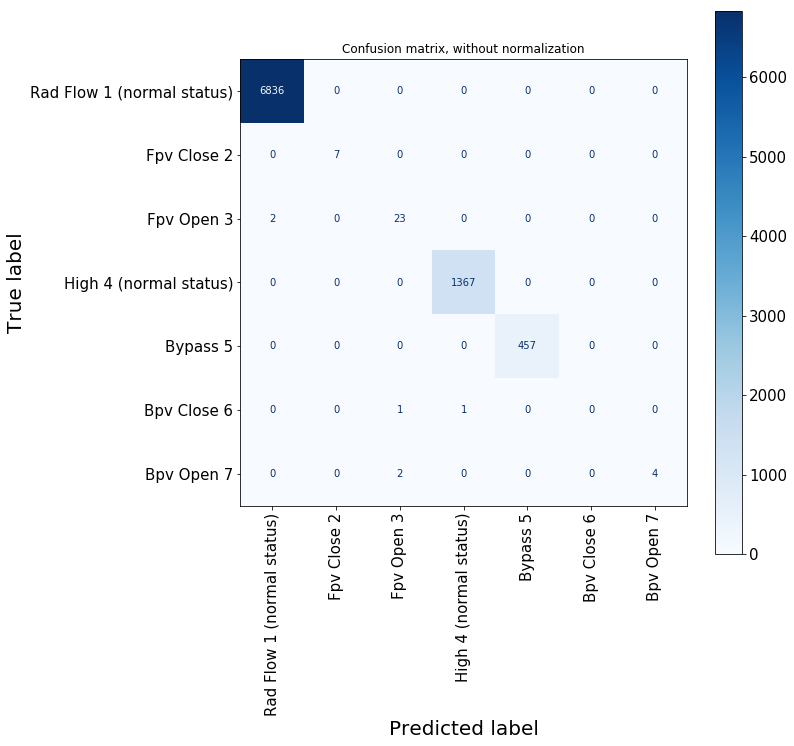

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(rf_clf, test_x, test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
plt.xticks( rotation='vertical')
disp.ax_.set_title("Confusion matrix, without normalization")

- **feature importance**
    

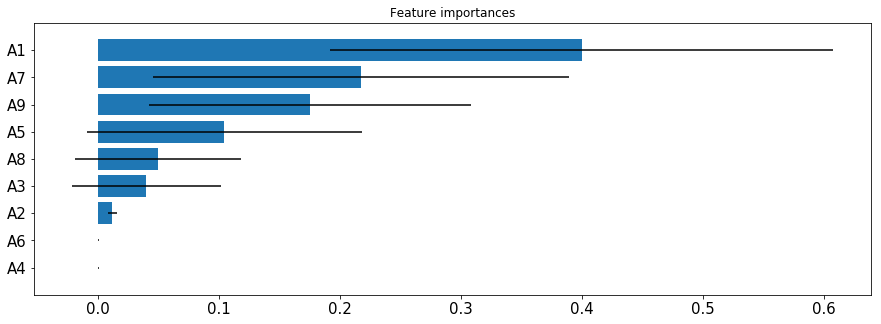

In [14]:

# Get feature importance using 'RandomForestClassifier'-
fi_rfc = pd.DataFrame({'feature_importance_scores': rf_clf.feature_importances_, 'attributes': train_col_names[:-1]})
# Sort in descending order-
fi_rfc.sort_values('feature_importance_scores', ascending=False, inplace=True)
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure(figsize=(15,5))
plt.title("Feature importances")
plt.barh(range(train_x.shape[1]), importances[indices], xerr=std[indices], align="center")
yticks = [train_col_names[i] for i in indices]
plt.yticks(range(len(indices)),yticks)
plt.ylim([-1, train_x.shape[1]])
plt.show()


    As inferred earlier, A2 and A4 attribute are not important for predictions

# Anomaly Detection with unsupervised learning 

It is often impractical or impossible to predict anamalies on fixed rules or with supervised machine learning methods, because of following reasons: 
    
- failures are too expensive.
        
        In order to collect data on machine anamalies, many data sets are collected through run-to-fail experiments. If it is an expensive machine, the cost of an anamaly may be expensive.
        
- failures are too complex.
        
        devices are too new to adequately characterize both normal and failure modes in a specific environment, or the environment changes and puts the device into an unpredictable condition
        
        

The goal of Anomaly detection with unsupervised learning is to successfully divide normal and abnormal classes without using label information. It generally proceed in two steps. 
    
    The first step is to characterize a normal baseline model( Negative Selection Algorithms,  One-class classifiers and Autoencoder and generative methods)
    
    The second step is to score each new data point as normal or anomalous.
    
    
In this notebook, we will show the Agglomerative Clustering method .

- **dataset**

    In order to form the unsupervised learning dataset, The smallest five classes, i.e. 2, 3, 5, 6, 7 are combined to form the anomaly class, while class 1 and 4 form the normal class. Data for class 4 is discarded.

In [45]:
# load the data
train_col_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'Class']
training_data = pd.read_csv("data/train.csv", index_col=[0],header=[0])
training_data.columns = train_col_names
Anamaly_df = training_data.copy()
#  class 1 and 4 form the normal class
Anamaly_df.loc[(Anamaly_df["Class"]==1)| (Anamaly_df["Class"]==4),'Class']=1
#  classes 2, 3, 5, 6, 7 are combined to form the anomaly class
Anamaly_df.loc[(Anamaly_df["Class"]!=1),'Class']=2

Anamaly_df["orginal class"] = training_data["Class"]
# Preprocessing normailisation
feature_x = Anamaly_df.drop(columns=["Class","orginal class"])
mean = feature_x.mean()
std = feature_x.std()
std.replace(0, 1, inplace=True)
feature_x = (feature_x - mean) / std

# label 
biniary_label = Anamaly_df["Class"]
multi_label = Anamaly_df["orginal class"]

**There are 40856 normal data. There are 2644 abnormal data, accounting for 6% of the total data**

**There are two models below, the difference lies in the defined number of clusters**

    - When the number of clusters is equal to 7, the model is expected to automatically recognize seven different states without knowing the label
    - When the number of clusters is equal to 2, the model is expected to automatically distinguish between normal and abnormal states without knowing the label

**Agglomerative Clustering with cluster = 7**

- **Baseline** 
    If the prediction is always the most class

In [46]:
Multi_Prediction = pd.Series(1,index=multi_label.index)
accuracy = accuracy_score(multi_label, Multi_Prediction)
print("The baseline (overall accuracy) is : ", accuracy)

from sklearn.metrics import balanced_accuracy_score
balanced_accuracy = balanced_accuracy_score(multi_label, Multi_Prediction)
print("The baseline (balanced accuracy) is ",balanced_accuracy)

The baseline (overall accuracy) is :  0.7840919540229885
The baseline (balanced accuracy) is  0.14285714285714285


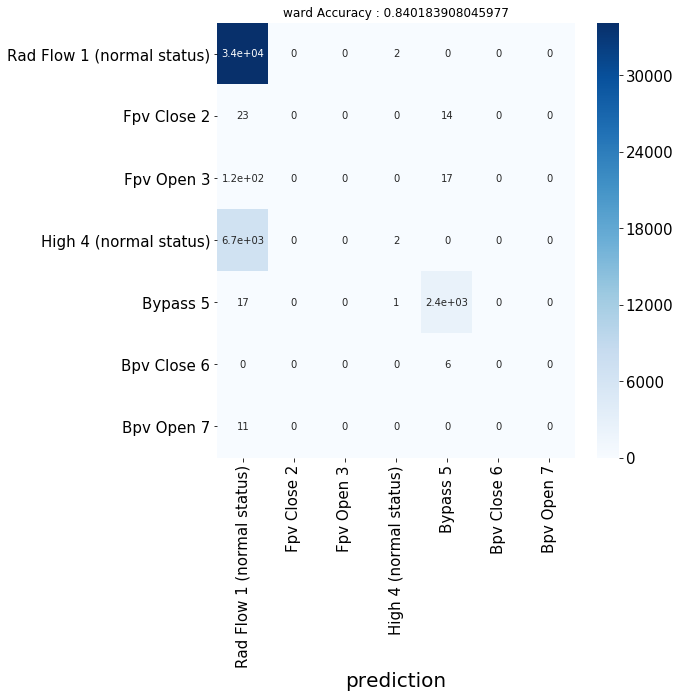

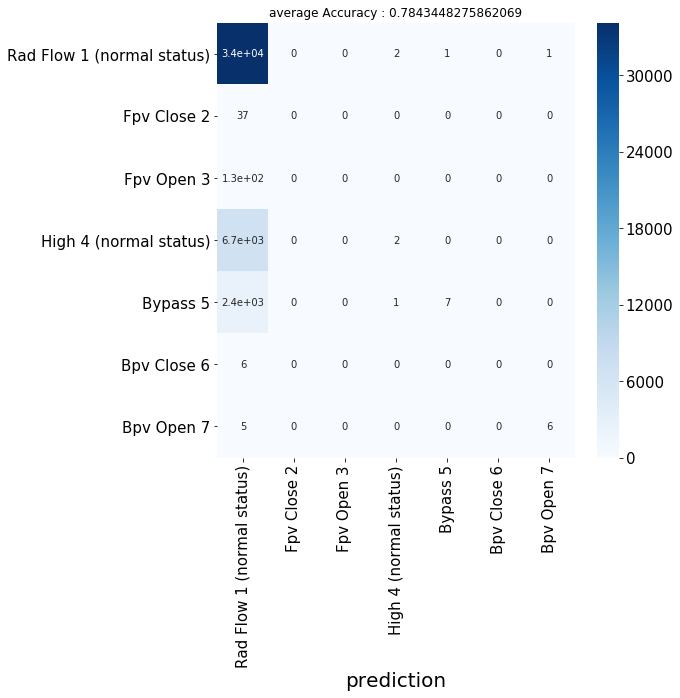

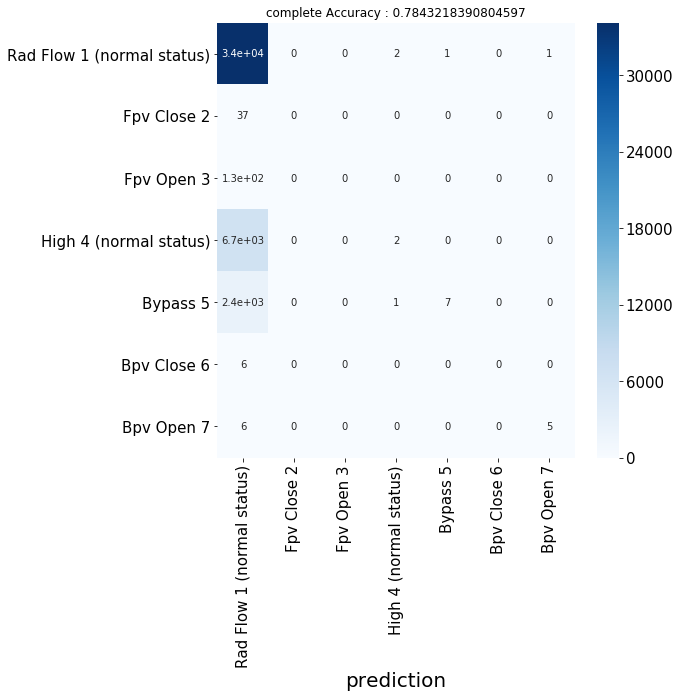

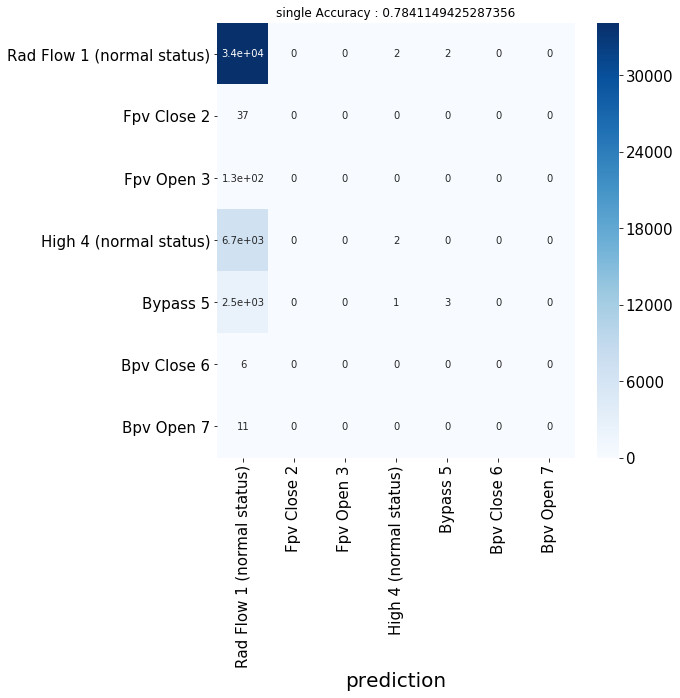

In [19]:
for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=7)
    clustering.fit(feature_x)
    Multi_Prediction = pd.Series(np.nan,index=multi_label.index)
    # clustering labels might be permuted. Let’s select all points from each cluster 
    # and check their labels from the original data labels. Then we use the dominant 
    # label for the whole cluster. In essence, we are renaming the clusters, not re-clustering the data.
    for i in range(7):
        Multi_Prediction[clustering.labels_==i] = multi_label[clustering.labels_==i].value_counts().index[0]
    fig, ax = plt.subplots(figsize=(8, 8))
    accuracy_rf = accuracy_score(multi_label, Multi_Prediction)
    cf_matrix = confusion_matrix(multi_label,Multi_Prediction)
    sns.heatmap(cf_matrix, annot=True,cmap=plt.cm.Blues,ax=ax, yticklabels=class_names, xticklabels = class_names, )
    plt.xlabel("prediction")
    plt.title(linkage + " Accuracy : " + str(accuracy_rf))
    plt.show()    
    

**Agglomerative Clustering with cluster = 2**

In [47]:
Multi_Prediction = pd.Series(1,index=multi_label.index)
accuracy = accuracy_score(biniary_label, Multi_Prediction)
print("The baseline is : ", accuracy)


from sklearn.metrics import balanced_accuracy_score
balanced_accuracy = balanced_accuracy_score(biniary_label, Multi_Prediction)
print("The baseline (balanced accuracy) is ",balanced_accuracy)

The baseline is :  0.9392183908045977
The baseline (balanced accuracy) is  0.5


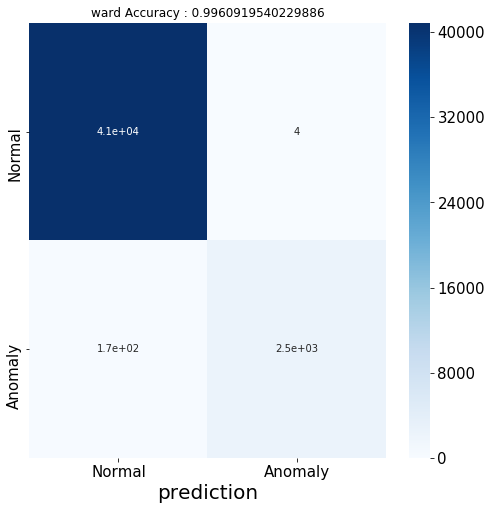

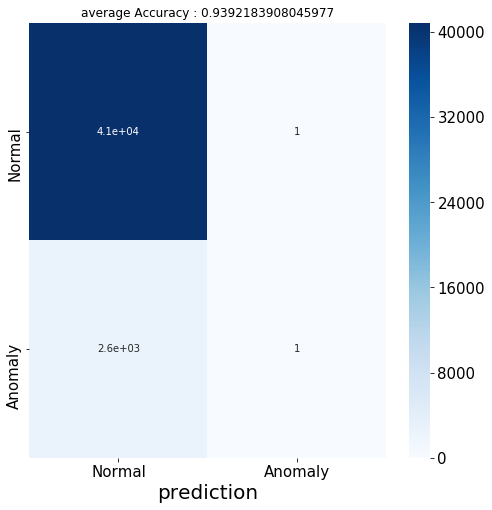

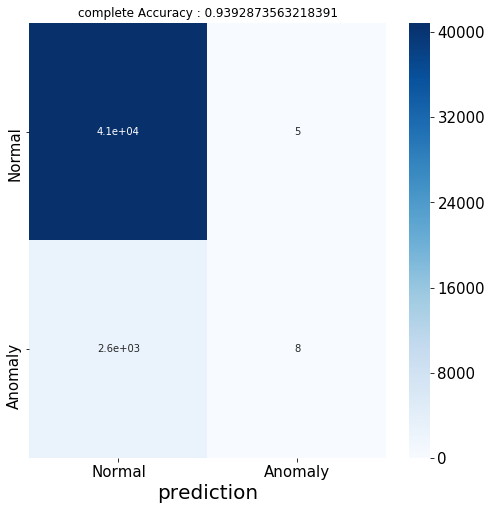

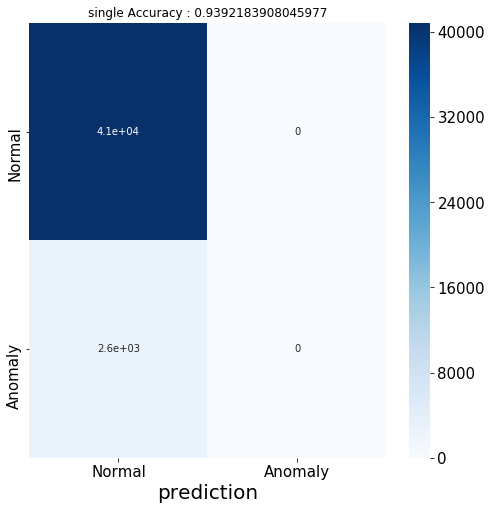

In [19]:
class_names = ["Normal","Anomaly"]

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=2)
    clustering.fit(feature_x)
    Multi_Prediction = pd.Series(np.nan,index=biniary_label.index)
    # clustering labels might be permuted. Let’s select all points from each cluster 
    # and check their labels from the original data labels. Then we use the dominant 
    # label for the whole cluster. In essence, we are renaming the clusters, not re-clustering the data.
    for i in range(2):
        Multi_Prediction[clustering.labels_==i] = biniary_label[clustering.labels_==i].value_counts().index[0]
    fig, ax = plt.subplots(figsize=(8, 8))
    accuracy_rf = accuracy_score(biniary_label, Multi_Prediction)
    cf_matrix = confusion_matrix(biniary_label,Multi_Prediction)
    sns.heatmap(cf_matrix, annot=True,cmap=plt.cm.Blues,ax=ax, yticklabels=class_names, xticklabels = class_names, )
    plt.xlabel("prediction")
    plt.title(linkage + " Accuracy : " + str(accuracy_rf))
    plt.show()    
    

In [ ]:
When ward linkage criterion is used, The model achieved an accuracy of 99.6

**In the next notebook we will show using one class svm and semi-supervised learning to deal with this problem to get better results**